In [1]:
# ========================================
# 05_ablation_studies.ipynb
# Ablation Studies on U-Net
# ========================================

# ----- Cell 1: Mount Google Drive -----
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ----- Cell 2: Setup project paths -----
import os

PROJECT_ROOT = '/content/drive/MyDrive/SHBT 261/Mini_Project_2'
os.chdir(PROJECT_ROOT)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/drive/MyDrive/SHBT 261/Mini_Project_2


In [3]:
# ----- Cell 3: Install dependencies -----
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q kagglehub

print("✓ Dependencies installed")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.5 MB/s eta 0:00:00
✓ Dependencies installed


In [4]:
# ----- Cell 4: Import libraries -----
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [5]:
# ----- Cell 5: Load dataset -----
import kagglehub
from torchvision.datasets import VOCSegmentation

dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

trainval_candidates = ['VOCtrainval_06-Nov-2007', 'voctrainval_06-nov-2007']
VOC_ROOT = None
for candidate in trainval_candidates:
    candidate_path = os.path.join(dataset_path, candidate)
    if os.path.exists(os.path.join(candidate_path, 'VOCdevkit', 'VOC2007')):
        VOC_ROOT = candidate_path
        break

print(f"✓ VOC_ROOT: {VOC_ROOT}")

VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = 21
print(f"✓ Number of classes: {NUM_CLASSES}")

Using Colab cache for faster access to the 'pascal-voc-2007' dataset.
✓ VOC_ROOT: /kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007
✓ Number of classes: 21


In [6]:
# ----- Cell 6: Define transforms -----
import albumentations as A
from albumentations.pytorch import ToTensorV2

# WITH augmentation (baseline)
train_transform_aug = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# WITHOUT augmentation (ablation 1)
train_transform_no_aug = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Validation transform (same for both)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

print("✓ Transforms defined")

✓ Transforms defined


In [7]:
# ----- Cell 7: Custom Dataset -----
from torch.utils.data import Dataset
from PIL import Image

class VOCSegmentationAlbumentations(Dataset):
    def __init__(self, root, year, image_set, transform=None):
        self.voc = VOCSegmentation(root=root, year=year, image_set=image_set, download=False)
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        image, mask = self.voc[idx]
        image = np.array(image)
        mask = np.array(mask)
        mask[mask == 255] = 0

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        mask = mask.long()

        return image, mask

print("✓ Dataset class defined")

✓ Dataset class defined


In [8]:
# ----- Cell 8: Define metrics and training functions -----
def calculate_iou(pred, target, num_classes=21):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())

    return ious

def calculate_pixel_accuracy(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    correct = (pred == target).sum().float()
    total = target.numel()
    return (correct / total).item()

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
        batch_acc = calculate_pixel_accuracy(preds, masks)

        running_loss += loss.item()
        running_iou.append(batch_iou)
        running_acc += batch_acc

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{batch_acc:.4f}'})

    return running_loss / len(dataloader), np.nanmean(running_iou), running_acc / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            running_loss += loss.item()
            running_iou.append(batch_iou)
            running_acc += batch_acc

            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{batch_acc:.4f}'})

    return running_loss / len(dataloader), np.nanmean(running_iou), running_acc / len(dataloader)

print("✓ Training functions defined")

✓ Training functions defined


In [9]:
# ========================================
# ABLATION 1: U-Net WITHOUT Augmentation
# ========================================

print("\n" + "=" * 70)
print("ABLATION 1: U-Net WITHOUT Data Augmentation")
print("=" * 70)


ABLATION 1: U-Net WITHOUT Data Augmentation


In [10]:
# ----- Cell 10: Create datasets (NO augmentation) -----
train_dataset_noaug = VOCSegmentationAlbumentations(
    root=VOC_ROOT, year="2007", image_set="train", transform=train_transform_no_aug
)

val_dataset_noaug = VOCSegmentationAlbumentations(
    root=VOC_ROOT, year="2007", image_set="val", transform=val_transform
)

train_loader_noaug = DataLoader(
    train_dataset_noaug, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, drop_last=True
)

val_loader_noaug = DataLoader(
    val_dataset_noaug, batch_size=8, shuffle=False, num_workers=2, pin_memory=True
)

print(f"✓ Train samples: {len(train_dataset_noaug)}")
print(f"✓ Val samples: {len(val_dataset_noaug)}")

✓ Train samples: 209
✓ Val samples: 213


In [12]:
# ----- Cell 11: Create model (NO aug) -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_noaug = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_noaug = optim.Adam(model_noaug.parameters(), lr=1e-4)
scheduler_noaug = optim.lr_scheduler.ReduceLROnPlateau(optimizer_noaug, mode='min', factor=0.5, patience=5)

print(f"✓ U-Net (No Aug) created on {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✓ U-Net (No Aug) created on cuda


In [13]:
# ----- Cell 12: Train U-Net (NO augmentation) -----
NUM_EPOCHS = 20  # Reduced epochs for ablation

best_val_iou_noaug = 0.0
history_noaug = {'train_loss': [], 'train_iou': [], 'train_acc': [], 'val_loss': [], 'val_iou': [], 'val_acc': []}

print(f"\nTraining U-Net WITHOUT augmentation for {NUM_EPOCHS} epochs...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_iou, train_acc = train_epoch(model_noaug, train_loader_noaug, criterion, optimizer_noaug, device)
    val_loss, val_iou, val_acc = validate(model_noaug, val_loader_noaug, criterion, device)
    scheduler_noaug.step(val_loss)

    history_noaug['train_loss'].append(train_loss)
    history_noaug['train_iou'].append(train_iou)
    history_noaug['train_acc'].append(train_acc)
    history_noaug['val_loss'].append(val_loss)
    history_noaug['val_iou'].append(val_iou)
    history_noaug['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    if val_iou > best_val_iou_noaug:
        best_val_iou_noaug = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_noaug.state_dict(),
            'val_iou': val_iou,
        }, f'{PROJECT_ROOT}/models/unet_noaug_best.pth')
        print(f"✓ Best model saved! (IoU: {val_iou:.4f})")

training_time_noaug = time.time() - start_time

print(f"\n✓ Training complete! Time: {training_time_noaug/60:.2f} minutes")
print(f"✓ Best validation IoU: {best_val_iou_noaug:.4f}")

# Save final model
torch.save({
    'model_state_dict': model_noaug.state_dict(),
    'history': history_noaug,
    'best_val_iou': best_val_iou_noaug,
    'training_time': training_time_noaug,
}, f'{PROJECT_ROOT}/models/unet_noaug_final.pth')


Training U-Net WITHOUT augmentation for 20 epochs...

Epoch 1/20


Validation: 100%|██████████| 27/27 [00:04<00:00,  6.40it/s, loss=2.5406, acc=0.3902]


Train Loss: 2.7294 | Train IoU: 0.0204 | Train Acc: 0.2306
Val Loss:   2.6343 | Val IoU:   0.0344 | Val Acc:   0.3619
✓ Best model saved! (IoU: 0.0344)

Epoch 2/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.89it/s, loss=1.9846, acc=0.6503]


Train Loss: 2.2970 | Train IoU: 0.0513 | Train Acc: 0.5304
Val Loss:   2.0467 | Val IoU:   0.0707 | Val Acc:   0.6441
✓ Best model saved! (IoU: 0.0707)

Epoch 3/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 15.63it/s, loss=1.7839, acc=0.6789]


Train Loss: 1.9683 | Train IoU: 0.0782 | Train Acc: 0.6794
Val Loss:   1.8180 | Val IoU:   0.0745 | Val Acc:   0.6988
✓ Best model saved! (IoU: 0.0745)

Epoch 4/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.08it/s, loss=1.5619, acc=0.7342]


Train Loss: 1.7034 | Train IoU: 0.0966 | Train Acc: 0.7371
Val Loss:   1.6594 | Val IoU:   0.0821 | Val Acc:   0.7277
✓ Best model saved! (IoU: 0.0821)

Epoch 5/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.25it/s, loss=1.4448, acc=0.7336]


Train Loss: 1.5027 | Train IoU: 0.1072 | Train Acc: 0.7711
Val Loss:   1.4677 | Val IoU:   0.0920 | Val Acc:   0.7656
✓ Best model saved! (IoU: 0.0920)

Epoch 6/20


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.77it/s, loss=1.3086, acc=0.7432]


Train Loss: 1.3244 | Train IoU: 0.1193 | Train Acc: 0.7977
Val Loss:   1.3071 | Val IoU:   0.0996 | Val Acc:   0.7874
✓ Best model saved! (IoU: 0.0996)

Epoch 7/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.99it/s, loss=1.1625, acc=0.7578]


Train Loss: 1.1939 | Train IoU: 0.1251 | Train Acc: 0.8059
Val Loss:   1.1560 | Val IoU:   0.1034 | Val Acc:   0.8009
✓ Best model saved! (IoU: 0.1034)

Epoch 8/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.73it/s, loss=1.1026, acc=0.7340]


Train Loss: 1.0634 | Train IoU: 0.1365 | Train Acc: 0.8210
Val Loss:   1.0868 | Val IoU:   0.1115 | Val Acc:   0.8070
✓ Best model saved! (IoU: 0.1115)

Epoch 9/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.85it/s, loss=1.0689, acc=0.7547]


Train Loss: 0.9667 | Train IoU: 0.1493 | Train Acc: 0.8304
Val Loss:   1.0257 | Val IoU:   0.1130 | Val Acc:   0.8023
✓ Best model saved! (IoU: 0.1130)

Epoch 10/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.50it/s, loss=0.9927, acc=0.7673]


Train Loss: 0.9053 | Train IoU: 0.1450 | Train Acc: 0.8278
Val Loss:   0.9787 | Val IoU:   0.1118 | Val Acc:   0.8119

Epoch 11/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.98it/s, loss=0.9627, acc=0.7683]


Train Loss: 0.8438 | Train IoU: 0.1483 | Train Acc: 0.8378
Val Loss:   0.9309 | Val IoU:   0.1223 | Val Acc:   0.8139
✓ Best model saved! (IoU: 0.1223)

Epoch 12/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.59it/s, loss=0.9363, acc=0.7670]


Train Loss: 0.7792 | Train IoU: 0.1588 | Train Acc: 0.8401
Val Loss:   0.9054 | Val IoU:   0.1192 | Val Acc:   0.8175

Epoch 13/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.12it/s, loss=0.9708, acc=0.7822]


Train Loss: 0.7362 | Train IoU: 0.1707 | Train Acc: 0.8503
Val Loss:   0.8911 | Val IoU:   0.1240 | Val Acc:   0.8132
✓ Best model saved! (IoU: 0.1240)

Epoch 14/20


Validation: 100%|██████████| 27/27 [00:03<00:00,  8.55it/s, loss=0.9865, acc=0.7773]


Train Loss: 0.6912 | Train IoU: 0.1848 | Train Acc: 0.8574
Val Loss:   0.8694 | Val IoU:   0.1249 | Val Acc:   0.8173
✓ Best model saved! (IoU: 0.1249)

Epoch 15/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.62it/s, loss=0.9329, acc=0.7856]


Train Loss: 0.6561 | Train IoU: 0.1791 | Train Acc: 0.8593
Val Loss:   0.8491 | Val IoU:   0.1290 | Val Acc:   0.8227
✓ Best model saved! (IoU: 0.1290)

Epoch 16/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.61it/s, loss=0.9648, acc=0.7756]


Train Loss: 0.6278 | Train IoU: 0.1859 | Train Acc: 0.8630
Val Loss:   0.8245 | Val IoU:   0.1311 | Val Acc:   0.8188
✓ Best model saved! (IoU: 0.1311)

Epoch 17/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.98it/s, loss=0.9563, acc=0.7657]


Train Loss: 0.6128 | Train IoU: 0.1883 | Train Acc: 0.8645
Val Loss:   0.8503 | Val IoU:   0.1316 | Val Acc:   0.8091
✓ Best model saved! (IoU: 0.1316)

Epoch 18/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.62it/s, loss=1.0625, acc=0.7714]


Train Loss: 0.5690 | Train IoU: 0.2052 | Train Acc: 0.8708
Val Loss:   0.8198 | Val IoU:   0.1389 | Val Acc:   0.8237
✓ Best model saved! (IoU: 0.1389)

Epoch 19/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.41it/s, loss=1.0317, acc=0.7786]


Train Loss: 0.5554 | Train IoU: 0.2045 | Train Acc: 0.8765
Val Loss:   0.7938 | Val IoU:   0.1367 | Val Acc:   0.8217

Epoch 20/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 16.00it/s, loss=1.0135, acc=0.7847]


Train Loss: 0.5259 | Train IoU: 0.2122 | Train Acc: 0.8805
Val Loss:   0.7826 | Val IoU:   0.1464 | Val Acc:   0.8267
✓ Best model saved! (IoU: 0.1464)

✓ Training complete! Time: 2.18 minutes
✓ Best validation IoU: 0.1464


In [14]:
# ========================================
# ABLATION 2: U-Net with ResNet18
# ========================================

print("\n" + "=" * 70)
print("ABLATION 2: U-Net with ResNet18 Backbone")
print("=" * 70)


ABLATION 2: U-Net with ResNet18 Backbone


In [15]:
# ----- Cell 14: Create datasets (with augmentation, ResNet18) -----
train_dataset_r18 = VOCSegmentationAlbumentations(
    root=VOC_ROOT, year="2007", image_set="train", transform=train_transform_aug
)

val_dataset_r18 = VOCSegmentationAlbumentations(
    root=VOC_ROOT, year="2007", image_set="val", transform=val_transform
)

train_loader_r18 = DataLoader(
    train_dataset_r18, batch_size=8, shuffle=True, num_workers=2, pin_memory=True, drop_last=True
)

val_loader_r18 = DataLoader(
    val_dataset_r18, batch_size=8, shuffle=False, num_workers=2, pin_memory=True
)

print(f"✓ Train samples: {len(train_dataset_r18)}")
print(f"✓ Val samples: {len(val_dataset_r18)}")

✓ Train samples: 209
✓ Val samples: 213


In [16]:
# ----- Cell 15: Create model (ResNet18) -----
model_r18 = smp.Unet(
    encoder_name="resnet18",  # Changed to ResNet18
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(device)

optimizer_r18 = optim.Adam(model_r18.parameters(), lr=1e-4)
scheduler_r18 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_r18, mode='min', factor=0.5, patience=5)

total_params = sum(p.numel() for p in model_r18.parameters())
print(f"✓ U-Net (ResNet18) created on {device}")
print(f"✓ Parameters: {total_params:,}")

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

✓ U-Net (ResNet18) created on cuda
✓ Parameters: 14,331,109


In [17]:
# ----- Cell 16: Train U-Net (ResNet18) -----
NUM_EPOCHS = 20

best_val_iou_r18 = 0.0
history_r18 = {'train_loss': [], 'train_iou': [], 'train_acc': [], 'val_loss': [], 'val_iou': [], 'val_acc': []}

print(f"\nTraining U-Net with ResNet18 for {NUM_EPOCHS} epochs...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_iou, train_acc = train_epoch(model_r18, train_loader_r18, criterion, optimizer_r18, device)
    val_loss, val_iou, val_acc = validate(model_r18, val_loader_r18, criterion, device)
    scheduler_r18.step(val_loss)

    history_r18['train_loss'].append(train_loss)
    history_r18['train_iou'].append(train_iou)
    history_r18['train_acc'].append(train_acc)
    history_r18['val_loss'].append(val_loss)
    history_r18['val_iou'].append(val_iou)
    history_r18['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    if val_iou > best_val_iou_r18:
        best_val_iou_r18 = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_r18.state_dict(),
            'val_iou': val_iou,
        }, f'{PROJECT_ROOT}/models/unet_resnet18_best.pth')
        print(f"✓ Best model saved! (IoU: {val_iou:.4f})")

training_time_r18 = time.time() - start_time

print(f"\n✓ Training complete! Time: {training_time_r18/60:.2f} minutes")
print(f"✓ Best validation IoU: {best_val_iou_r18:.4f}")

# Save final model
torch.save({
    'model_state_dict': model_r18.state_dict(),
    'history': history_r18,
    'best_val_iou': best_val_iou_r18,
    'training_time': training_time_r18,
}, f'{PROJECT_ROOT}/models/unet_resnet18_final.pth')


Training U-Net with ResNet18 for 20 epochs...

Epoch 1/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.44it/s, loss=2.8268, acc=0.2895]


Train Loss: 3.2225 | Train IoU: 0.0089 | Train Acc: 0.0653
Val Loss:   3.2337 | Val IoU:   0.0203 | Val Acc:   0.1593
✓ Best model saved! (IoU: 0.0203)

Epoch 2/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.95it/s, loss=2.4750, acc=0.6299]


Train Loss: 2.8397 | Train IoU: 0.0320 | Train Acc: 0.2636
Val Loss:   2.6457 | Val IoU:   0.0476 | Val Acc:   0.4142
✓ Best model saved! (IoU: 0.0476)

Epoch 3/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 15.58it/s, loss=2.2820, acc=0.6762]


Train Loss: 2.5912 | Train IoU: 0.0522 | Train Acc: 0.4083
Val Loss:   2.4148 | Val IoU:   0.0641 | Val Acc:   0.5198
✓ Best model saved! (IoU: 0.0641)

Epoch 4/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.54it/s, loss=2.0041, acc=0.7429]


Train Loss: 2.3347 | Train IoU: 0.0684 | Train Acc: 0.5193
Val Loss:   2.1979 | Val IoU:   0.0718 | Val Acc:   0.6144
✓ Best model saved! (IoU: 0.0718)

Epoch 5/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 15.73it/s, loss=1.8856, acc=0.7671]


Train Loss: 2.1098 | Train IoU: 0.0772 | Train Acc: 0.6544
Val Loss:   1.9571 | Val IoU:   0.0807 | Val Acc:   0.7266
✓ Best model saved! (IoU: 0.0807)

Epoch 6/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 15.58it/s, loss=1.7500, acc=0.7317]


Train Loss: 1.8803 | Train IoU: 0.0881 | Train Acc: 0.7165
Val Loss:   1.8186 | Val IoU:   0.0829 | Val Acc:   0.7338
✓ Best model saved! (IoU: 0.0829)

Epoch 7/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.76it/s, loss=1.6717, acc=0.7643]


Train Loss: 1.6872 | Train IoU: 0.0917 | Train Acc: 0.7589
Val Loss:   1.6570 | Val IoU:   0.0857 | Val Acc:   0.7591
✓ Best model saved! (IoU: 0.0857)

Epoch 8/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.61it/s, loss=1.4467, acc=0.7572]


Train Loss: 1.5202 | Train IoU: 0.0952 | Train Acc: 0.7800
Val Loss:   1.4441 | Val IoU:   0.0878 | Val Acc:   0.7804
✓ Best model saved! (IoU: 0.0878)

Epoch 9/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.72it/s, loss=1.3747, acc=0.7702]


Train Loss: 1.3817 | Train IoU: 0.1036 | Train Acc: 0.7850
Val Loss:   1.4153 | Val IoU:   0.0939 | Val Acc:   0.7666
✓ Best model saved! (IoU: 0.0939)

Epoch 10/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.10it/s, loss=1.1750, acc=0.7757]


Train Loss: 1.2557 | Train IoU: 0.1060 | Train Acc: 0.7908
Val Loss:   1.2277 | Val IoU:   0.1024 | Val Acc:   0.7923
✓ Best model saved! (IoU: 0.1024)

Epoch 11/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.71it/s, loss=1.2846, acc=0.7442]


Train Loss: 1.1485 | Train IoU: 0.1161 | Train Acc: 0.8024
Val Loss:   1.2472 | Val IoU:   0.1008 | Val Acc:   0.7789

Epoch 12/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.13it/s, loss=1.0730, acc=0.7658]


Train Loss: 1.0722 | Train IoU: 0.1252 | Train Acc: 0.8077
Val Loss:   1.0943 | Val IoU:   0.1088 | Val Acc:   0.7966
✓ Best model saved! (IoU: 0.1088)

Epoch 13/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.81it/s, loss=1.0954, acc=0.7367]


Train Loss: 1.0074 | Train IoU: 0.1198 | Train Acc: 0.8054
Val Loss:   1.0603 | Val IoU:   0.1043 | Val Acc:   0.7836

Epoch 14/20


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.43it/s, loss=0.9822, acc=0.8037]


Train Loss: 0.9492 | Train IoU: 0.1220 | Train Acc: 0.8080
Val Loss:   1.0022 | Val IoU:   0.1128 | Val Acc:   0.7953
✓ Best model saved! (IoU: 0.1128)

Epoch 15/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.11it/s, loss=1.0092, acc=0.7511]


Train Loss: 0.8926 | Train IoU: 0.1264 | Train Acc: 0.8128
Val Loss:   0.9954 | Val IoU:   0.1016 | Val Acc:   0.7840

Epoch 16/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.54it/s, loss=0.9668, acc=0.7451]


Train Loss: 0.8586 | Train IoU: 0.1471 | Train Acc: 0.8217
Val Loss:   0.9484 | Val IoU:   0.1160 | Val Acc:   0.7965
✓ Best model saved! (IoU: 0.1160)

Epoch 17/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.24it/s, loss=0.9249, acc=0.7292]


Train Loss: 0.7825 | Train IoU: 0.1511 | Train Acc: 0.8346
Val Loss:   0.9253 | Val IoU:   0.1121 | Val Acc:   0.7948

Epoch 18/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.75it/s, loss=0.9305, acc=0.7488]


Train Loss: 0.7470 | Train IoU: 0.1591 | Train Acc: 0.8348
Val Loss:   0.9051 | Val IoU:   0.1191 | Val Acc:   0.7976
✓ Best model saved! (IoU: 0.1191)

Epoch 19/20


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.96it/s, loss=0.9309, acc=0.7512]


Train Loss: 0.7171 | Train IoU: 0.1574 | Train Acc: 0.8376
Val Loss:   0.8802 | Val IoU:   0.1317 | Val Acc:   0.8030
✓ Best model saved! (IoU: 0.1317)

Epoch 20/20


Validation: 100%|██████████| 27/27 [00:01<00:00, 19.14it/s, loss=0.8839, acc=0.7422]


Train Loss: 0.7081 | Train IoU: 0.1715 | Train Acc: 0.8427
Val Loss:   0.8566 | Val IoU:   0.1319 | Val Acc:   0.8010
✓ Best model saved! (IoU: 0.1319)

✓ Training complete! Time: 1.70 minutes
✓ Best validation IoU: 0.1319


In [18]:
# ========================================
# COMPARISON AND ANALYSIS
# ========================================

print("\n" + "=" * 70)
print("ABLATION STUDY RESULTS")
print("=" * 70)


ABLATION STUDY RESULTS


In [19]:
# ----- Cell 18: Load baseline results for comparison -----
import json

# Load U-Net (ResNet34 with aug) baseline results
with open(f'{PROJECT_ROOT}/results/unet_summary.json', 'r') as f:
    baseline_summary = json.load(f)

baseline_iou = baseline_summary['final_val_iou']
baseline_acc = baseline_summary['final_val_acc']

print("Baseline U-Net (ResNet34 + Augmentation):")
print(f"  IoU: {baseline_iou:.4f}")
print(f"  Acc: {baseline_acc:.4f}")

Baseline U-Net (ResNet34 + Augmentation):
  IoU: 0.1727
  Acc: 0.8213


In [20]:
# ----- Cell 19: Create comparison table -----
import pandas as pd

comparison_data = {
    'Model': [
        'U-Net (ResNet34 + Aug)',
        'U-Net (ResNet34, No Aug)',
        'U-Net (ResNet18 + Aug)'
    ],
    'IoU': [
        baseline_iou,
        best_val_iou_noaug,
        best_val_iou_r18
    ],
    'Accuracy': [
        baseline_acc,
        history_noaug['val_acc'][-1],
        history_r18['val_acc'][-1]
    ],
    'Training Time (min)': [
        baseline_summary['training_time_minutes'],
        training_time_noaug / 60,
        training_time_r18 / 60
    ],
    'Parameters': [
        baseline_summary['num_parameters'],
        sum(p.numel() for p in model_noaug.parameters()),
        sum(p.numel() for p in model_r18.parameters())
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "=" * 70)
print("ABLATION STUDY COMPARISON")
print("=" * 70)
print(df_comparison.to_string(index=False))
print("=" * 70)

# Save to CSV
df_comparison.to_csv(f'{PROJECT_ROOT}/results/ablation_comparison.csv', index=False)
print(f"\n✓ Comparison saved to: {PROJECT_ROOT}/results/ablation_comparison.csv")


ABLATION STUDY COMPARISON
                   Model      IoU  Accuracy  Training Time (min)  Parameters
  U-Net (ResNet34 + Aug) 0.172667  0.821280             3.592771    24439269
U-Net (ResNet34, No Aug) 0.146434  0.826698             2.175454    24439269
  U-Net (ResNet18 + Aug) 0.131917  0.801033             1.701525    14331109

✓ Comparison saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/ablation_comparison.csv


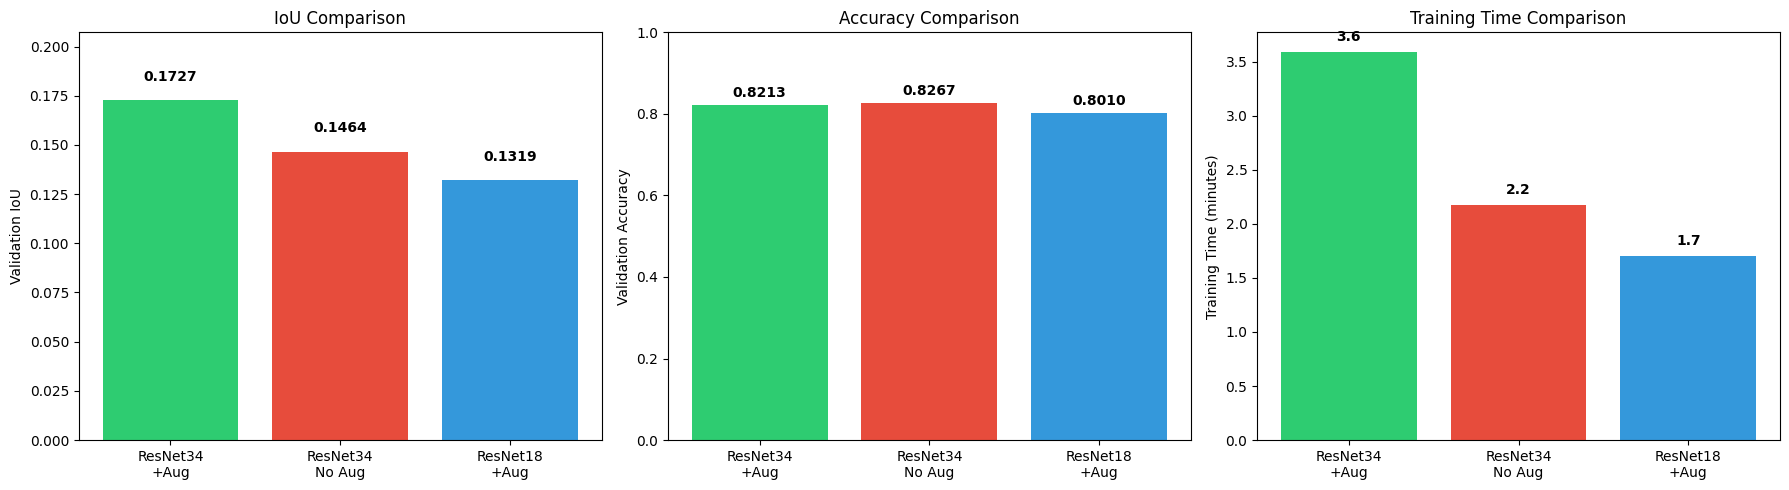

✓ Comparison plot saved


In [21]:
# ----- Cell 20: Plot comparison -----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = ['ResNet34\n+Aug', 'ResNet34\nNo Aug', 'ResNet18\n+Aug']
ious = [baseline_iou, best_val_iou_noaug, best_val_iou_r18]
accs = [baseline_acc, history_noaug['val_acc'][-1], history_r18['val_acc'][-1]]
times = [baseline_summary['training_time_minutes'], training_time_noaug/60, training_time_r18/60]

# IoU comparison
axes[0].bar(models, ious, color=['#2ecc71', '#e74c3c', '#3498db'])
axes[0].set_ylabel('Validation IoU')
axes[0].set_title('IoU Comparison')
axes[0].set_ylim([0, max(ious) * 1.2])
for i, v in enumerate(ious):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Accuracy comparison
axes[1].bar(models, accs, color=['#2ecc71', '#e74c3c', '#3498db'])
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Accuracy Comparison')
axes[1].set_ylim([0, 1])
for i, v in enumerate(accs):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Training time comparison
axes[2].bar(models, times, color=['#2ecc71', '#e74c3c', '#3498db'])
axes[2].set_ylabel('Training Time (minutes)')
axes[2].set_title('Training Time Comparison')
for i, v in enumerate(times):
    axes[2].text(i, v + 0.1, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/ablation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Comparison plot saved")

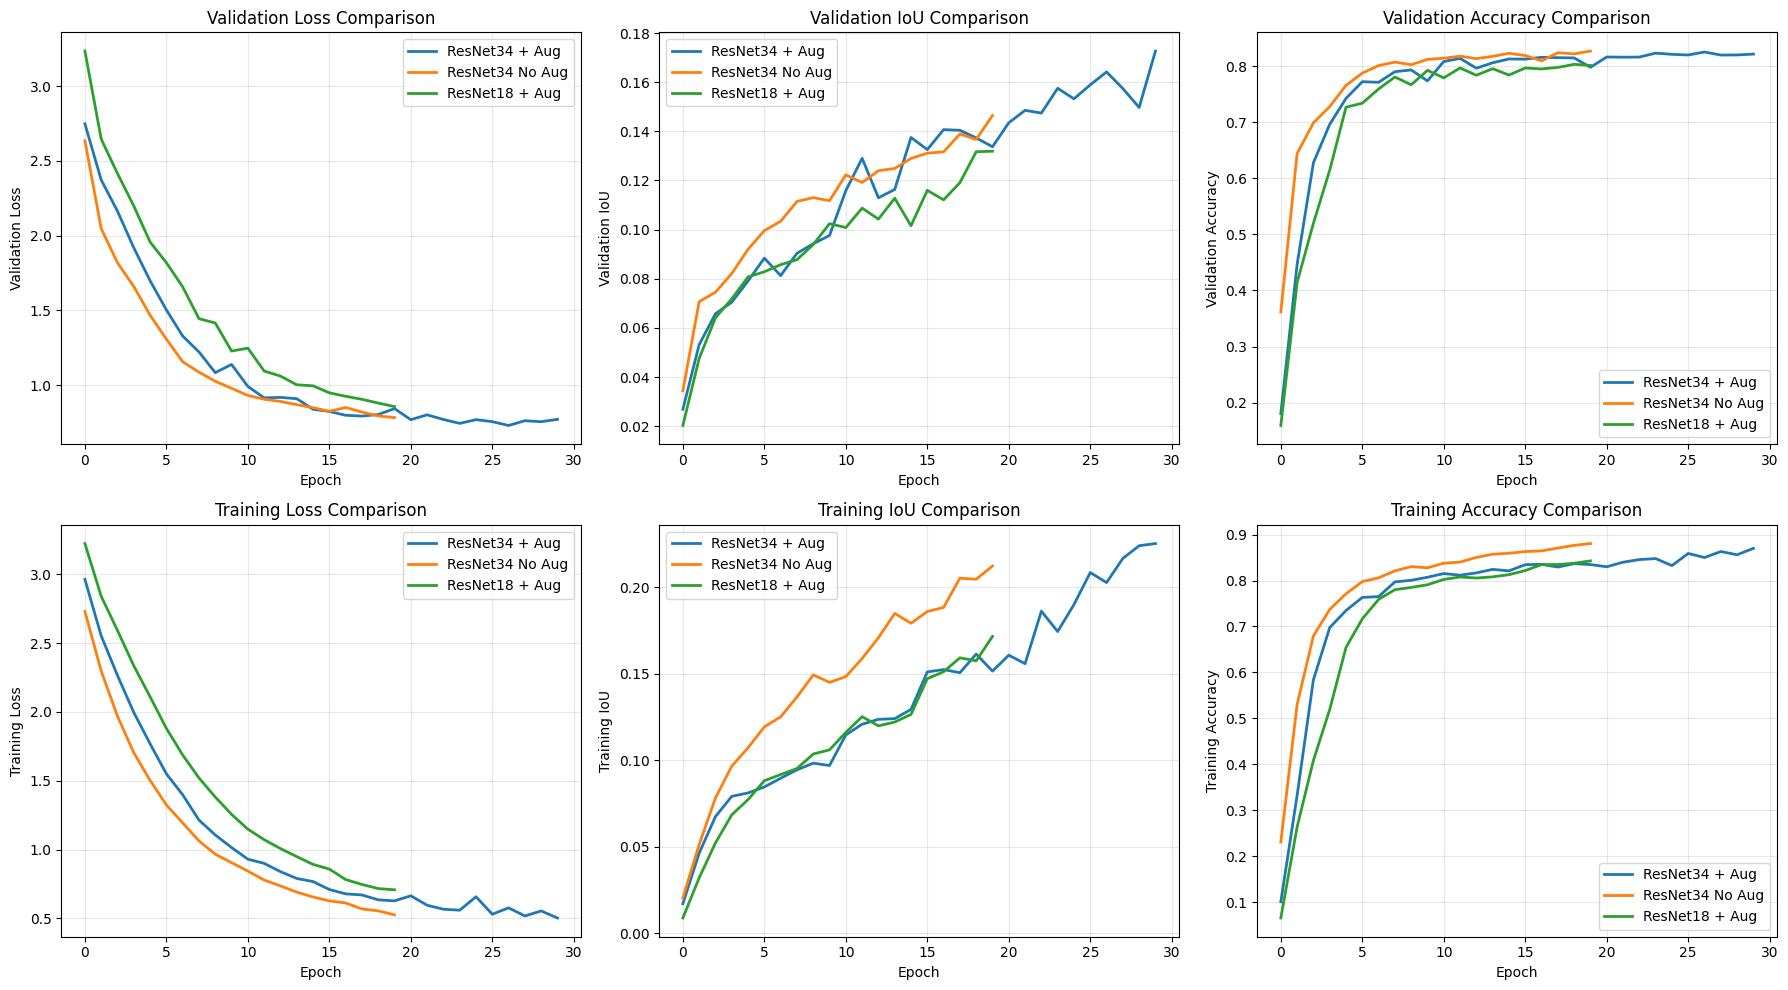

✓ Training curves comparison saved


In [22]:
# ----- Cell 21: Plot training curves comparison -----
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Load baseline history
baseline_checkpoint = torch.load(f'{PROJECT_ROOT}/models/unet_final.pth', weights_only=False)
baseline_history = baseline_checkpoint['history']

# Plot Loss
axes[0, 0].plot(baseline_history['val_loss'], label='ResNet34 + Aug', linewidth=2)
axes[0, 0].plot(history_noaug['val_loss'], label='ResNet34 No Aug', linewidth=2)
axes[0, 0].plot(history_r18['val_loss'], label='ResNet18 + Aug', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Validation Loss')
axes[0, 0].set_title('Validation Loss Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot IoU
axes[0, 1].plot(baseline_history['val_iou'], label='ResNet34 + Aug', linewidth=2)
axes[0, 1].plot(history_noaug['val_iou'], label='ResNet34 No Aug', linewidth=2)
axes[0, 1].plot(history_r18['val_iou'], label='ResNet18 + Aug', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation IoU')
axes[0, 1].set_title('Validation IoU Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot Accuracy
axes[0, 2].plot(baseline_history['val_acc'], label='ResNet34 + Aug', linewidth=2)
axes[0, 2].plot(history_noaug['val_acc'], label='ResNet34 No Aug', linewidth=2)
axes[0, 2].plot(history_r18['val_acc'], label='ResNet18 + Aug', linewidth=2)
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Validation Accuracy')
axes[0, 2].set_title('Validation Accuracy Comparison')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot training metrics
axes[1, 0].plot(baseline_history['train_loss'], label='ResNet34 + Aug', linewidth=2)
axes[1, 0].plot(history_noaug['train_loss'], label='ResNet34 No Aug', linewidth=2)
axes[1, 0].plot(history_r18['train_loss'], label='ResNet18 + Aug', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Training Loss')
axes[1, 0].set_title('Training Loss Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(baseline_history['train_iou'], label='ResNet34 + Aug', linewidth=2)
axes[1, 1].plot(history_noaug['train_iou'], label='ResNet34 No Aug', linewidth=2)
axes[1, 1].plot(history_r18['train_iou'], label='ResNet18 + Aug', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Training IoU')
axes[1, 1].set_title('Training IoU Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(baseline_history['train_acc'], label='ResNet34 + Aug', linewidth=2)
axes[1, 2].plot(history_noaug['train_acc'], label='ResNet34 No Aug', linewidth=2)
axes[1, 2].plot(history_r18['train_acc'], label='ResNet18 + Aug', linewidth=2)
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Training Accuracy')
axes[1, 2].set_title('Training Accuracy Comparison')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/ablation_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves comparison saved")

In [23]:
# ----- Cell 22: Key findings summary -----
print("\n" + "=" * 70)
print("KEY FINDINGS FROM ABLATION STUDIES")
print("=" * 70)

# Calculate differences
iou_diff_aug = ((baseline_iou - best_val_iou_noaug) / baseline_iou) * 100
iou_diff_backbone = ((baseline_iou - best_val_iou_r18) / baseline_iou) * 100

print("\n1. IMPACT OF DATA AUGMENTATION:")
print(f"   - With augmentation:    IoU = {baseline_iou:.4f}")
print(f"   - Without augmentation: IoU = {best_val_iou_noaug:.4f}")
print(f"   - Difference: {iou_diff_aug:.1f}% {'decrease' if iou_diff_aug > 0 else 'increase'}")
print(f"   - Conclusion: Data augmentation {'helps' if iou_diff_aug > 0 else 'hurts'} performance")

print("\n2. IMPACT OF BACKBONE SIZE:")
print(f"   - ResNet34: IoU = {baseline_iou:.4f}")
print(f"   - ResNet18: IoU = {best_val_iou_r18:.4f}")
print(f"   - Difference: {iou_diff_backbone:.1f}% {'decrease' if iou_diff_backbone > 0 else 'increase'}")
print(f"   - Conclusion: Larger backbone {'improves' if iou_diff_backbone > 0 else 'reduces'} performance")

print("\n" + "=" * 70)


KEY FINDINGS FROM ABLATION STUDIES

1. IMPACT OF DATA AUGMENTATION:
   - With augmentation:    IoU = 0.1727
   - Without augmentation: IoU = 0.1464
   - Difference: 15.2% decrease
   - Conclusion: Data augmentation helps performance

2. IMPACT OF BACKBONE SIZE:
   - ResNet34: IoU = 0.1727
   - ResNet18: IoU = 0.1319
   - Difference: 23.6% decrease
   - Conclusion: Larger backbone improves performance



In [24]:
# ----- Cell 23: Save ablation summaries -----
import json

# Save no-aug summary
summary_noaug = {
    'model': 'U-Net (No Augmentation)',
    'encoder': 'ResNet34',
    'augmentation': False,
    'num_epochs': NUM_EPOCHS,
    'best_val_iou': float(best_val_iou_noaug),
    'final_val_acc': float(history_noaug['val_acc'][-1]),
    'training_time_minutes': training_time_noaug / 60,
}

with open(f'{PROJECT_ROOT}/results/unet_noaug_summary.json', 'w') as f:
    json.dump(summary_noaug, f, indent=4)

# Save ResNet18 summary
summary_r18 = {
    'model': 'U-Net (ResNet18)',
    'encoder': 'ResNet18',
    'augmentation': True,
    'num_epochs': NUM_EPOCHS,
    'best_val_iou': float(best_val_iou_r18),
    'final_val_acc': float(history_r18['val_acc'][-1]),
    'training_time_minutes': training_time_r18 / 60,
}

with open(f'{PROJECT_ROOT}/results/unet_resnet18_summary.json', 'w') as f:
    json.dump(summary_r18, f, indent=4)

print("✓ Summaries saved")

✓ Summaries saved


In [25]:
# ----- Cell 24: Final summary -----
print("\n" + "=" * 70)
print("ABLATION STUDIES COMPLETE!")
print("=" * 70)
print("\nFiles saved:")
print(f"  1. U-Net (No Aug) model: {PROJECT_ROOT}/models/unet_noaug_best.pth")
print(f"  2. U-Net (ResNet18) model: {PROJECT_ROOT}/models/unet_resnet18_best.pth")
print(f"  3. Comparison table: {PROJECT_ROOT}/results/ablation_comparison.csv")
print(f"  4. Comparison plot: {PROJECT_ROOT}/results/ablation_comparison.png")
print(f"  5. Training curves: {PROJECT_ROOT}/results/ablation_training_curves.png")

print("\n" + "=" * 70)
print("OVERALL PROGRESS")
print("=" * 70)
print("1. ✓ U-Net (ResNet34 + Aug) - Baseline")
print("2. ✓ DeepLabV3+ - Better model")
print("3. ✓ SAM - Different architecture")
print("4. ✓ U-Net (No Aug) - Ablation 1")
print("5. ✓ U-Net (ResNet18) - Ablation 2")
print("6. → Next: Comprehensive evaluation with all metrics")
print("=" * 70)

print("\n✓ Ready for final evaluation notebook!")


ABLATION STUDIES COMPLETE!

Files saved:
  1. U-Net (No Aug) model: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/unet_noaug_best.pth
  2. U-Net (ResNet18) model: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/unet_resnet18_best.pth
  3. Comparison table: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/ablation_comparison.csv
  4. Comparison plot: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/ablation_comparison.png
  5. Training curves: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/ablation_training_curves.png

OVERALL PROGRESS
1. ✓ U-Net (ResNet34 + Aug) - Baseline
2. ✓ DeepLabV3+ - Better model
3. ✓ SAM - Different architecture
4. ✓ U-Net (No Aug) - Ablation 1
5. ✓ U-Net (ResNet18) - Ablation 2
6. → Next: Comprehensive evaluation with all metrics

✓ Ready for final evaluation notebook!
